In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
#import seaborn as sns; sns.set()
style.use('fivethirtyeight')
#formatting $$
import matplotlib.ticker as mtick
%matplotlib inline

#utility functions
from cleanup_utilities import misc


In [6]:
!ls -lash ./data/*.csv

3890712 -rw-r--r--  1 ptreszczotko  staff   1.9G Sep 14 09:00 ./data/fpdsAllCSV.csv
  89952 -rw-r--r--  1 ptreszczotko  staff    44M Sep 13 11:09 ./data/fpdsAllCSV100k.csv


# Read in 2016 federal spending data

In [9]:
#Bring in fpds 2016 data 
#this didnt work on a laptop with 16GBs of RAM
df = pd.read_csv('./data/fpdsAllCSV.csv',low_memory=True, dtype={'agencyID': str, 'PIID': str, 'modNumber': str, 'transactionNumber': int, 'obligatedAmount': float, 'baseAndExercisedOptionsValue': float, 'baseAndAllOptionsValue': float , 'DUNSNumber': str})



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,13,15,19,23,40,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
#how many columns were shifted during the import process?
badRows = df[df['status'] != 'F'] # should I drop them?
badRows.head(1)

,agencyID,PIID,modNumber,transactionNumber,IDVAgencyID,IDVPIID,IDVModificationNumber,signedDate,effectiveDate,currentCompletionDate,...,placeOfPerformanceCongressionalDistrict,extentCompeted,solicitationProcedures,typeOfSetAside,evaluatedPreference,numberOfOffersReceived,fedBizOpps,createdBy,lastModifiedBy,status
887489,3600,VA25515F0044,P00003,0,3600,V797P4237B,0,2015-10-09,2015-10-01,2016-09-30,...,A,NaN,NONE,NONE,NaN,0,N,2015-10-09 15:32:07,2017-03-01 10:25:40,NaN


# A bit of EDA first...

### Look at agencies that spend the most

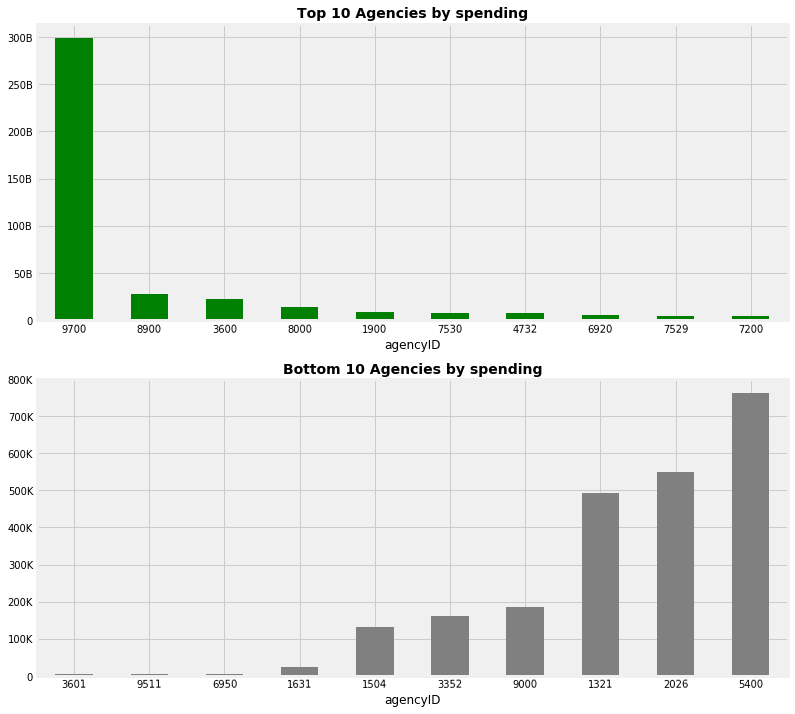

In [11]:
top_n = 10
mostSpent = df.groupby('agencyID')['obligatedAmount'].sum().sort_values(ascending=False)[:top_n]
leastSpent = df.groupby('agencyID')['obligatedAmount'].sum().sort_values(ascending=True)

#spending grater than 0
leastSpent = leastSpent[leastSpent > 0][:top_n]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

mostSpent.plot(kind='bar', x=mostSpent.index,y=mostSpent,
        align='center', width=.5, edgecolor='none', 
        color='green', ax=ax1, rot=1)

ax1.set_title('Top ' + str(top_n) + ' Agencies by spending',fontsize=14, fontweight='bold')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: misc.millify(x))) 

leastSpent.plot(kind='bar', x=mostSpent.index,y=mostSpent,
        align='center', width=.5, edgecolor='none', 
        color='gray', ax=ax2, rot=1)

ax2.set_title('Bottom ' + str(top_n) + ' Agencies by spending',fontsize=14, fontweight='bold')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: misc.millify(x))) 


### Convert AgencyIDs to their corresponding names

In [12]:
# Get another data set that maps agencyIds to their names
## Need to import FIPS-95

#import agecncyIds from FIPS 95-2
agencyNames = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR9NFxZhw7nn8RkJ7Y6UIjSbTObYlcNgwtlA9_dnaSFb2wmbEijgyEVCleQl6rwxxq61UhzgLm2Azmq/pub?output=csv', index_col='agencyID')
departmentName = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR9NFxZhw7nn8RkJ7Y6UIjSbTObYlcNgwtlA9_dnaSFb2wmbEijgyEVCleQl6rwxxq61UhzgLm2Azmq/pub?output=csv', index_col='departmentID')

#find agencies that are not in the lookup table and add them manually
missingAgencyIDs = df[~df['agencyID'].isin(agencyNames.index)]['agencyID'].unique()

#proceed when all agencies are filled in
missingAgencyIDs

array([], dtype=object)

In [14]:
# add agency names to mostSpent data frame
mostSpentWithNames = pd.merge(agencyNames,pd.DataFrame(mostSpent), left_index = True, right_index = True)

In [17]:
import pandas as pd
import plotly as plotly
#this is a free tier... let others use my api key :)
plotly.tools.set_credentials_file(username='ptreszczotko', api_key='Q5qCy6iLHSjNZznTDEXS');

graphData = pd.DataFrame(columns=['numberOfContracts'])
graphData['numberOfContracts'] = df[df['countryCode'] == 'USA']['state'].value_counts()
graphData['obligatedAmountPerState'] = df.groupby(df[df['countryCode'] == 'USA']['state'])['obligatedAmount'].sum()
graphData['text'] = graphData.index +'\'s total obligated amount: '+ graphData['obligatedAmountPerState'].apply(lambda x: misc.millify(x)).astype(str)

data = [ dict(
        type='choropleth',
        # Colorblind-friendly colors
        autocolorscale = True,
        locations = graphData.index,
        z = graphData['numberOfContracts'],
        locationmode = 'USA-states',
        text = graphData['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Number of contracts")
        ) ]

layout = dict(
        title = 'Number of contracts awarded in FY2016 per state.',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'))
    
fig = dict( data=data, layout=layout );
plotly.plotly.iplot( fig, filename='d3-cloropleth-map' )

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~ptreszczotko/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


In [45]:
#try clustering by $ figures

#are there any contracts with null or NA contract value?
df[df['obligatedAmount'].isnull()].shape[0]

df[df.columns[20:49]]
#vendorName or vendorLegalOrganizationName, productOrServiceCode, principalNAICSCode


from sklearn.cluster import KMeans
import seaborn as sns; sns.set()

X = df[['obligatedAmount','vendorName', 'productOrServiceCode', 'principalNAICSCode', 'numberOfEmployees']]
X.set_index('vendorName', inplace=True)

